# Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

%matplotlib inline

# Load Data

In [2]:
df_training = pd.read_csv(r'C:\Users\Maxime\Documents\Formation\Coding\ML\BCG Forage\Task 3\training_data.csv')
df_training_hist = pd.read_csv(r'C:\Users\Maxime\Documents\Formation\Coding\ML\BCG Forage\Task 3\training_data_hist.csv')
df_training = df_training.drop(['Unnamed: 0', 'date_first_activ'], axis = 1)
df_training_hist = df_training_hist.drop('Unnamed: 0', axis = 1)

# Fonctions coming from previous task

In [3]:
def plot_stacked_bars(dataframe, title_, size_=(18,10), rot_=0, legend_="upper right"):
    
    """
    Plot stacked bars with annotations
    """
    
    ax = dataframe.plot(kind="bar", stacked=True, figsize=size_, rot=rot_, title=title_)
    
    # Annotate bars
    annotate_stacked_bars(ax,textsize=14)
    
    # Rename legend
    plt.legend(["Retention","Churn"], loc=legend_)
    
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()
    
def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    
    """
    Add value annotations to the bars
    """
    
    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        
        # Calculate annotation
        value=str(round(p.get_height(),1))
        
        # If value is 0 do not annotate
        if value=='0.0':
            continue
            
        ax.annotate(value,((p.get_x()+p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
                    color=colour,size=textsize,)


# Previous Treatment of the Data

Based on the conclusion from the previous taks, we need to adress to main points :

- The distribution of a few features is skewed to the right, which need to be corrected as some algorithms are sensible tp this parameter ;
- On top of that, we need to get rid of outliers.

We will finally be able to focus on the computation of new features


## Reducing Skewness

We try three transformation and see which one provides the best results.

In [4]:
skewed_columns = ['cons_12m', 
                  'cons_gas_12m', 
                  'cons_last_month', 
                  'forecast_cons_12m', 
                  'forecast_cons_year', 
                  'forecast_meter_rent_12m', 
                  'imp_cons']

for column in skewed_columns :
    
    df_training.loc[df_training[column] < 0, column] = np.nan
    df_training[column]+=1
    df_training[column] = np.log(df_training[column])

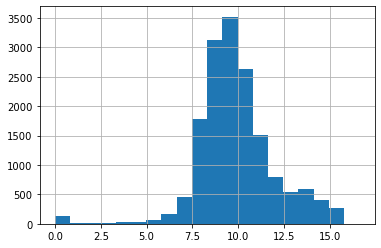

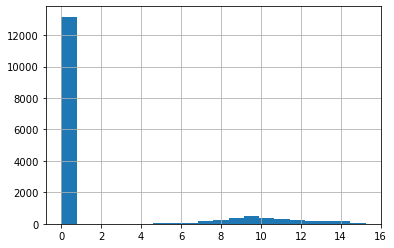

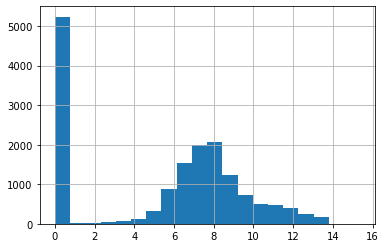

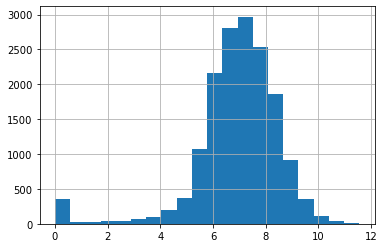

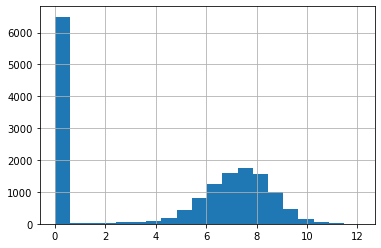

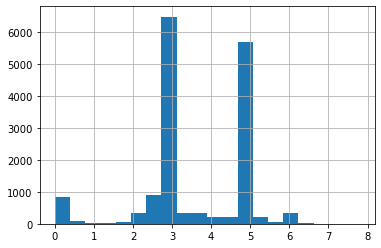

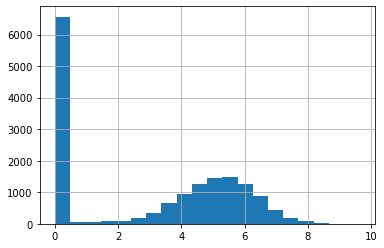

In [5]:
for column in skewed_columns :
    df_training[column].hist(bins = 20)
    plt.show()

--> We choose the **log option** which guarantee a better distribution of the data

## Removing Outliers

A classic way to spot outliers is to use the **interquartile range (IQR)** as follow :

In [6]:
Q1 = df_training.describe().iloc[4]
Q3 = df_training.describe().iloc[6]

IQR = Q3 - Q1
IQR = IQR[IQR != 0]

max_range = Q3[IQR.index] + 1.5*IQR
min_range = Q1[IQR.index] - 1.5*IQR

In [7]:
for column in IQR.index :
    df_training.loc[(df_training[column] < min_range[column]) | (df_training[column] > max_range[column]), column] = np.nan

In [8]:
imputer = SimpleImputer(strategy = 'median')
df_training[IQR.index] = imputer.fit_transform(df_training[IQR.index])

## Removing highly correlated features

Before computing new features, we need to ensure some of our features are not highly correlated. Otherwise, it could diminish the performances of our algorithms.

In [9]:
numerical_features = ['cons_12m', 
 'cons_gas_12m', 
 'cons_last_month', 
 'forecast_cons_12m', 
 'forecast_cons_year', 
 'forecast_discount_energy', 
 'forecast_meter_rent_12m', 
 'forecast_price_energy_p1', 
 'forecast_price_energy_p2', 
 'forecast_price_pow_p1', 
 'imp_cons', 
 'margin_gross_pow_ele', 
 'margin_net_pow_ele', 
 'nb_prod_act',
 'net_margin', 
 'num_years_antig', 
 'pow_max']

corr_matrix = df_training[numerical_features].corr()

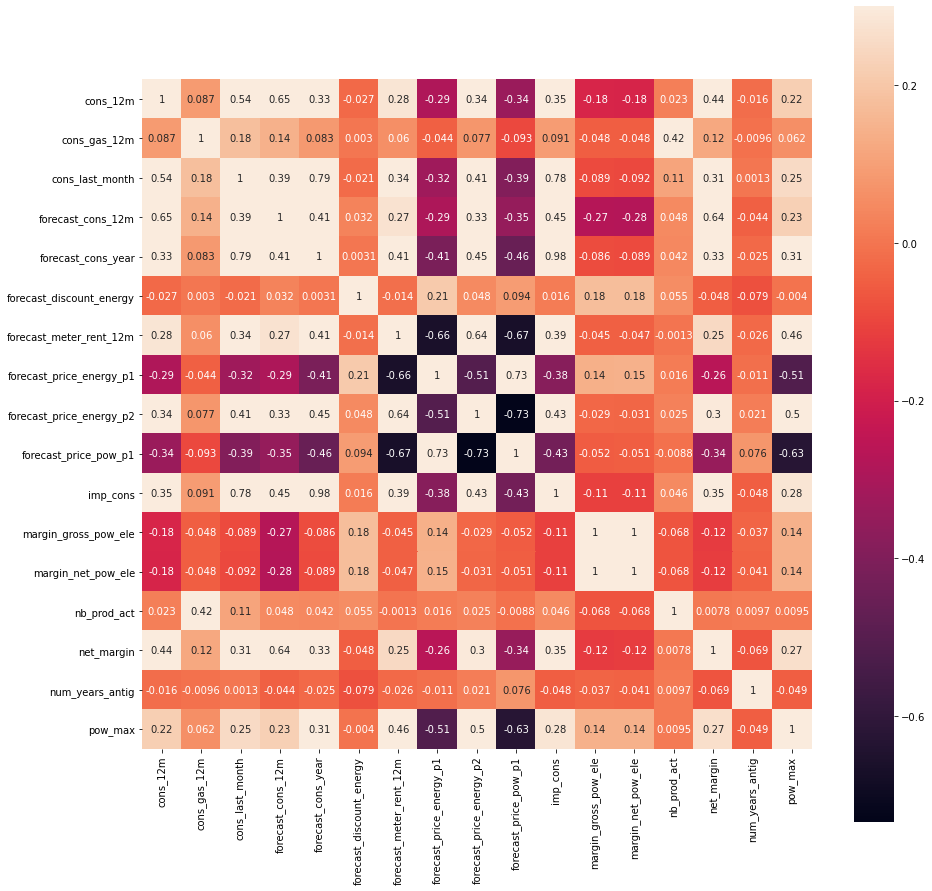

In [10]:
f, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(corr_matrix, vmax=0.3, square=True, annot = True)

The is no value that stands out particularly. We will not be deleting any features because of colinearity. 

# Feature Engineering

## 1. Computation based on historical data 

In [11]:
df_training_hist = df_training_hist.drop('price_date', axis = 1)

KeyError: "['price_date'] not found in axis"

In [ ]:
consumption_var = df_training_hist[['id', 'price_p1_var', 'price_p2_var', 'price_p3_var']].groupby('id').sum()
consumption_var_tot = consumption_var.sum(axis = 1)

consumption_fix = df_training_hist[['id', 'price_p1_fix', 'price_p2_fix', 'price_p3_fix']].groupby('id').sum()
consumption_fix_tot = consumption_fix.sum(axis = 1)

consumption_max =  df_training_hist.groupby('id').sum().max(axis = 1)
consumption_min =  df_training_hist.groupby('id').sum().min(axis = 1)

In [ ]:
df_training = df_training.join(consumption_var_tot.rename('consumption_var_tot'), on = 'id')
df_training = df_training.join(consumption_fix_tot.rename('consumption_fix_tot'), on = 'id')
df_training = df_training.join(consumption_max.rename('consumption_max'), on = 'id')
df_training = df_training.join(consumption_min.rename('consumption_min'), on = 'id')

## 2. Features from dates

In [12]:
imputer = SimpleImputer(strategy = 'most_frequent')
df_training[['date_end', 'date_activ', 'date_renewal']] = imputer.fit_transform(df_training[['date_end', 'date_activ', 'date_renewal']])

In [13]:
timestamp_end = []
timestamp_activ = []
timestamp_renewal = []

for date1, date2, date3 in zip(df_training['date_end'], df_training['date_activ'],  df_training['date_renewal']) :

    timestamp_end.append(dt.datetime.strptime(date1, '%Y-%m-%d').timestamp())
    timestamp_activ.append(dt.datetime.strptime(date2, '%Y-%m-%d').timestamp())
    timestamp_renewal.append(dt.datetime.strptime(date3, '%Y-%m-%d').timestamp())
    
timestamp_end = np.array(timestamp_end)
timestamp_activ = np.array(timestamp_activ)
timestamp_renewal = np.array(timestamp_renewal)

In [14]:
duration = timestamp_end - timestamp_activ
renewal = timestamp_renewal - timestamp_activ

df_training['duration'] = duration
df_training['renewal'] = renewal

## Change from Ordinal to OneHot Encoder

We will also change our encoding to OneHot because otherwise the model will believe the data labeled 1 is more related to the data labeled 4 per example, which is not the case a fortiori. 

In [15]:
dummy_encoder = OneHotEncoder()
dummy_variables = dummy_encoder.fit_transform(df_training[['channel_sales', 'has_gas', 'origin_up']])

In [16]:
dummy_encoder.categories_

[array([0., 1., 2., 3., 4., 5., 6.]),
 array([0., 1.]),
 array([0., 1., 2., 3., 4.])]

In [17]:
categorical_features = pd.DataFrame(dummy_variables.toarray(), 
             columns = [f'channel_sales_{i}' for i in range(7)] 
                     + [f'has_gas_{i}' for i in range(2)]
                     + [f'origin_up_{i}' for i in range(5)])

In [18]:
df_training = df_training.join(categorical_features)
df_training = df_training.drop(['channel_sales', 'has_gas', 'origin_up'], axis = 1)

In [19]:
df_training.to_csv('training_data.csv')